# 1

#### En el ejemplo de teoría hemos visto la forma de entrenar utilizando un trozo de datos como en la imagen "way1.png". 

(Básicamente, tener en cuenta más datos de entrenamiento [[20% de test]])

Investiga la forma de realizar el ejercicio a partir del gif "way3_sliding_window.gif":

- ¿Da mejores resultados entrenar el modelo así?

Algo muy típico en el trabajo de data scientist

![](../theory/sliding_windows_google.png)

In [135]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

### Creating dataset

In [136]:
# Total time points
N = 3000
# Time point to partition train/test splits
Tp = int(N * 0.8)  # For 80% train 20% test
t = np.arange(0, N)
x = (2 * np.sin(0.02 * t) * np.sin(0.003 * t)) + 0.5 * np.random.normal(size=N)
df = pd.DataFrame(x, columns=['Data'])
len(df)

3000

In [137]:
df.head()

Data
0 -0.411943
1 -0.925573
2  0.450691
3 -1.439447
4  0.824148

In [138]:
# Splitting data
values = df.values
train, test = values[0: Tp, :], values[Tp: N, :]

In [139]:
print("Train data shape:", train.shape)
print("Test data shape:", test.shape)

Train data shape: (2400, 1)
Test data shape: (600, 1)


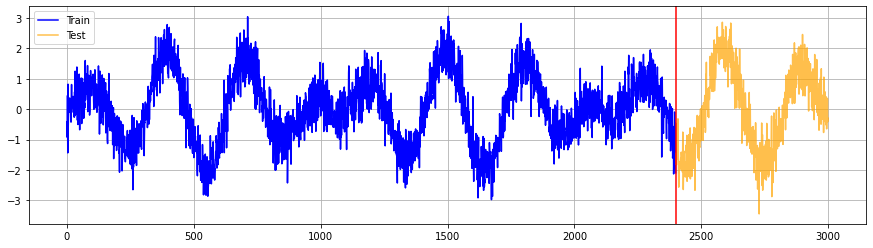

In [140]:
# Plottind Data
index = df.index.values
plt.figure(figsize=(15,4))
plt.plot(index[0:Tp], train,c='blue')
plt.plot(index[Tp:N], test,c='orange',alpha=0.7)
plt.legend(['Train', 'Test'])
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.show()

In [141]:
step = 4

# add step elements into train and test
test = np.append(test, np.repeat(test[-1, ], step))
train = np.append(train, np.repeat(train[-1, ], step))

In [142]:
# This useful function converts our data into X, which consists of len(X) vectors of the embedding length, and Y, which consists of len(X) labels in a time-continous fashion along our dataset
def convertToMatrix(data, step):
    X, Y = [], []
    for i in range(len(data) - step):
        d = i + step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [143]:
# Applying the function to our dataset
trainX, trainY = convertToMatrix(train, step)
testX, testY = convertToMatrix(test, step)
# This converts our data into trainX, which consists of 2400 vectors of the embedding length(4) and trainY, which consists of 2400 labels in a time-continous fashion along our dataset

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2400, 4)
(2400,)
(600, 4)
(600,)


In [144]:
# Para que Keras no se pique, en vez de darle 2400 vectores de longitud 4 le damos 2400 matrices de tamaño 1x4
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (2400, 1, 4) ,  (2400,)
Test data shape: (600, 1, 4) ,  (600,)


### Building a RNN model

In [145]:
def build_simple_rnn(num_units=128, embedding=4,num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1, embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr), metrics=['mse'])
    
    return model

In [146]:
model = build_simple_rnn() # Taking the default values

In [147]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_21 (SimpleRNN)    (None, 128)               17024     
_________________________________________________________________
dense_42 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 33        
Total params: 21,185
Trainable params: 21,185
Non-trainable params: 0
_________________________________________________________________


In [148]:
# This class will be used for a message to be shown every 50 epochs instead of every 1 to save time
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

In [149]:
# Defining parameters to fit the model
batch_size=16
num_epochs = 200

In [150]:
# Fitting the model
model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done


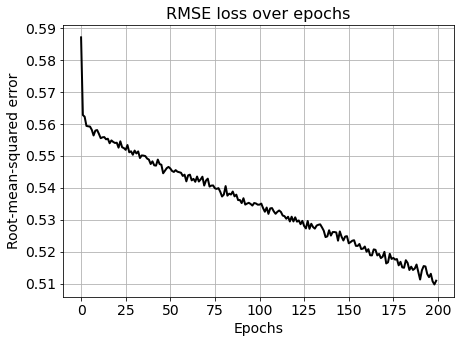

In [151]:
# Plotting the RMSE of each epoch
plt.figure(figsize=(7, 5))
plt.title("RMSE loss over epochs", fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']), c='k', lw=2)
plt.grid(True)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Root-mean-squared error", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

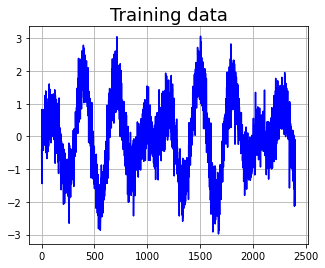

In [152]:
# Plotting the data the model was trained with
plt.figure(figsize=(5, 4))
plt.title("Training data", fontsize=18)
plt.plot(trainX[:,0][:,0], c='blue')
plt.grid(True)
plt.show()

In [153]:
# Making predictions
trainPredict = model.predict(trainX) # Predicting the train data to compare later
testPredict = model.predict(testX)
predicted = np.concatenate((trainPredict, testPredict), axis=0) 
# Joining the train and test predictions for plotting

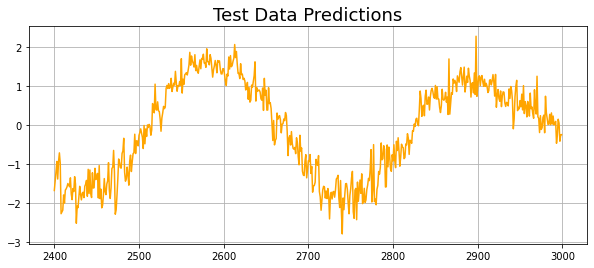

In [154]:
# Plotting the predictions of the test set
index = df.index.values
plt.figure(figsize=(10, 4))
plt.title("Test Data Predictions", fontsize=18)
plt.plot(index[Tp:], testPredict, c='orange')
plt.grid(True)
plt.show()

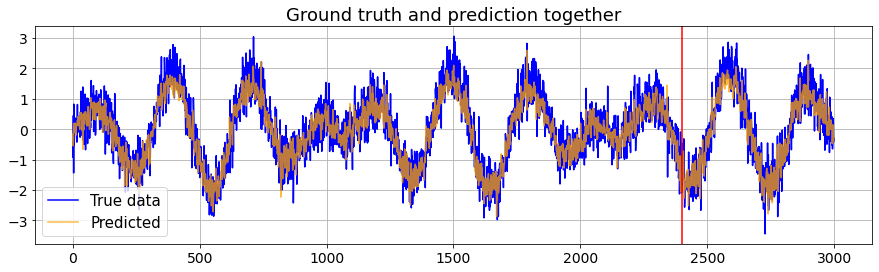

In [155]:
# Plotting predictions vs true data for the whole dataset, not just the test set
index = df.index.values
plt.figure(figsize=(15, 4))
plt.title("Predicted Data vs True Data", fontsize=18)
plt.plot(index, df, c='blue')
plt.plot(index, predicted, c='orange', alpha=0.75)
plt.legend(['True data', 'Predicted'], fontsize=15)
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Defining some functions to prepare, predict and plot data

In [156]:
# A simple function that receives a trained model and predicts for training data, test data and joins both so we have a prediction of the entire dataset
def predictions(model, trainX, testX):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    predicted = np.concatenate((trainPredict,testPredict),axis=0)
    
    return predicted

In [157]:
# A function that receives predicted data and plots real data vs predicted data
def plot_compare(predicted):
    index = df.index.values
    plt.figure(figsize=(15, 4))
    plt.title("Predicted Data VS True Data", fontsize=18)
    plt.plot(index, df, c='blue')
    plt.plot(index, predicted, c='orange', alpha=0.75)
    plt.legend(['True data', 'Predicted'], fontsize=15)
    plt.axvline(df.index[Tp], c="r")
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [158]:
# A function that receives a step size and delivers the dataset split into train and test with the appropriate shape to load into keras
def prepare_data(step=4):
    values = df.values
    train, test = values[0: Tp, :], values[Tp: N, :]
    test = np.append(test, np.repeat(test[-1,], step))
    train = np.append(train, np.repeat(train[-1,], step))
    trainX, trainY = convertToMatrix(train, step)
    testX, testY = convertToMatrix(test, step)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    return trainX, testX, trainY, testY

In [159]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# A function that calculates errors for predicted vs real values
def errors(testX, df):
    y_true = df[Tp: N].values
    y_pred = model.predict(testX)
    error = y_pred - y_true
    return [mean_absolute_error(y_true=y_true, y_pred=y_pred)]

# Model Optimization

### Testing for different embedding sizes

Embedding size: 2
Error: [0.3232345489500592]
----------------------------------------------------------------------------------------------------


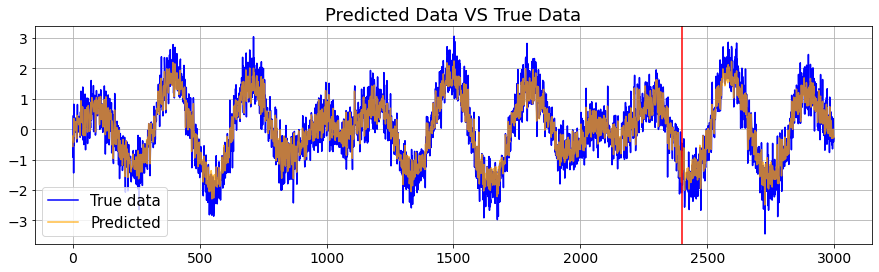


Embedding size: 4
Error: [0.3899525506170822]
----------------------------------------------------------------------------------------------------


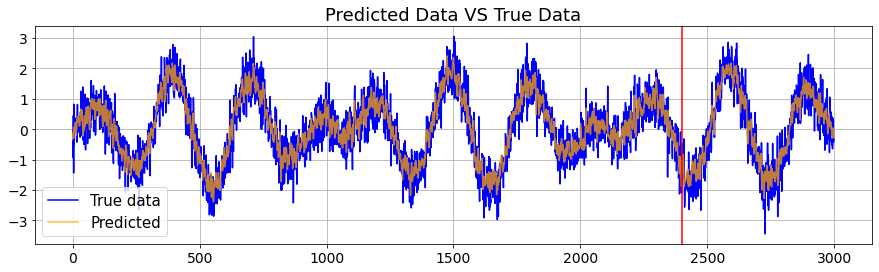


Embedding size: 6
Error: [0.3893785595642271]
----------------------------------------------------------------------------------------------------


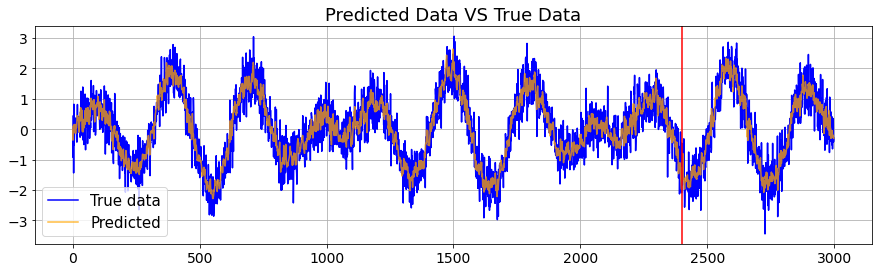


Embedding size: 8
Error: [0.3973963893826437]
----------------------------------------------------------------------------------------------------


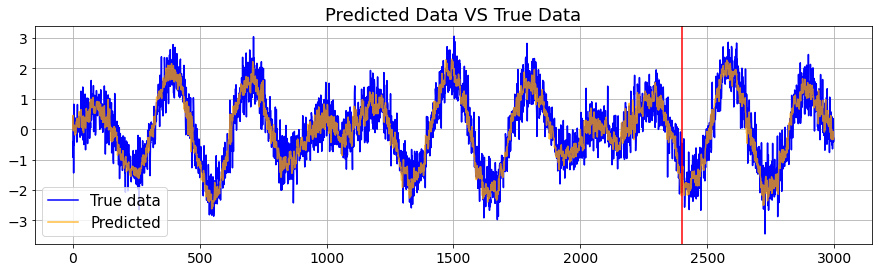


Embedding size: 10
Error: [0.4346421175319686]
----------------------------------------------------------------------------------------------------


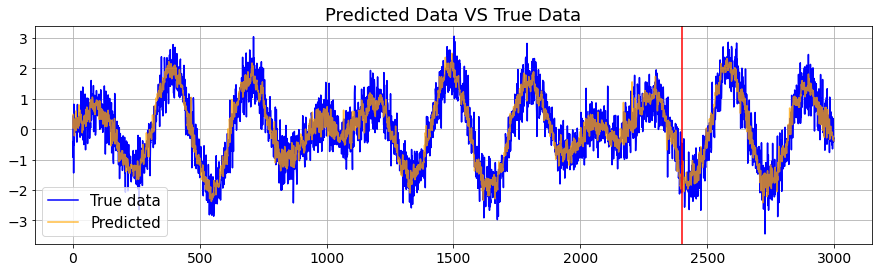


Embedding size: 12
Error: [0.44041514977386176]
----------------------------------------------------------------------------------------------------


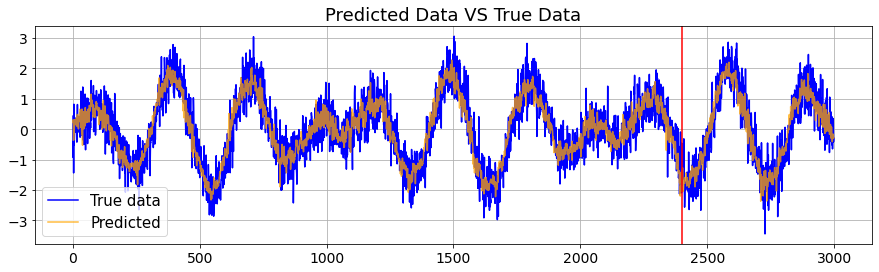

In [160]:
for s in [2, 4, 6, 8, 10, 12]:
    trainX, testX, trainY, testY = prepare_data(s)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=s)
    batch_size = 16
    num_epochs = 100
    model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, verbose=0)
    preds = predictions(model, trainX, testX)
    print("Embedding size: {}".format(s))
    print("Error:", errors(testX, df))
    print("-" * 100)
    plot_compare(preds)
    print()

The lowest error was yielded for `embedding size = 2` and the error grew as the embedding size got bigger for this model

### Testing for different number of epochs

Ran for 100 epochs
Error: [0.4023545570224493]
----------------------------------------------------------------------------------------------------


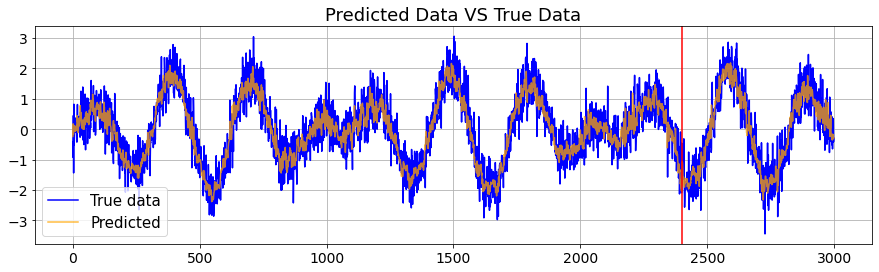


Ran for 200 epochs
Error: [0.4034308516479679]
----------------------------------------------------------------------------------------------------


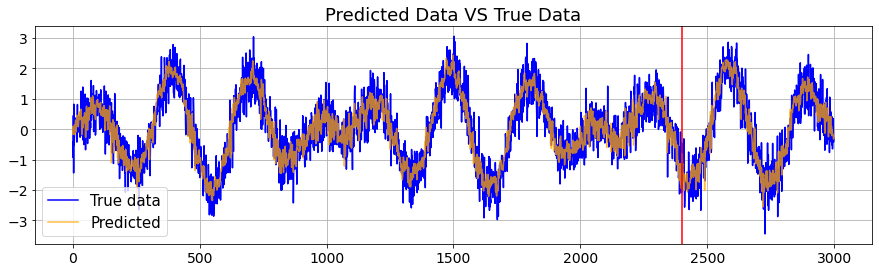


Ran for 300 epochs
Error: [0.41625762640988045]
----------------------------------------------------------------------------------------------------


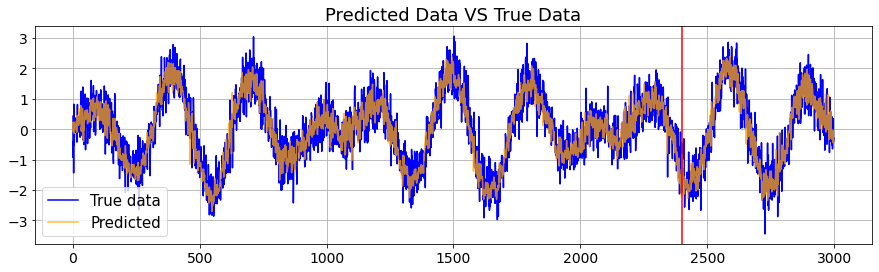


Ran for 400 epochs
Error: [0.4544813255017461]
----------------------------------------------------------------------------------------------------


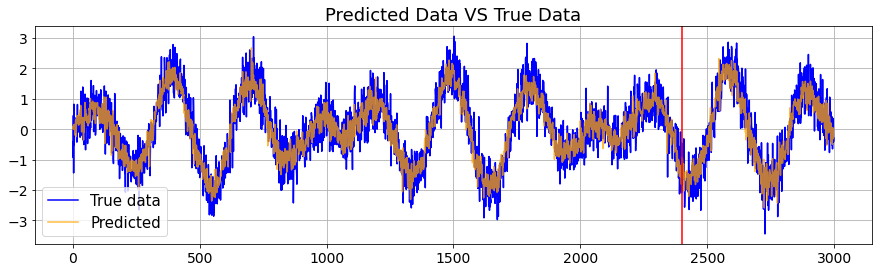


Ran for 500 epochs
Error: [0.4562780450334006]
----------------------------------------------------------------------------------------------------


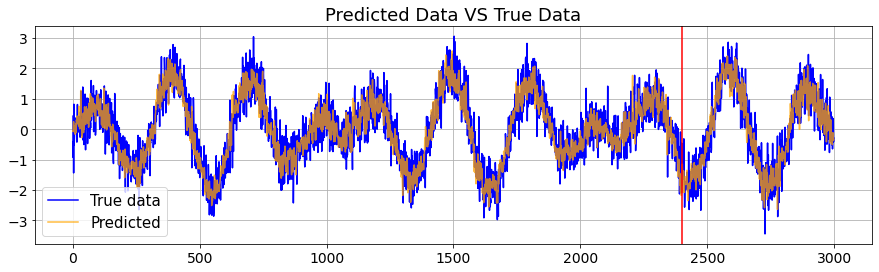

In [161]:
for e in [100, 200, 300, 400, 500]:
    trainX, testX, trainY, testY = prepare_data(8)
    model = build_simple_rnn(num_units=32, num_dense=8, embedding=8)
    batch_size = 16
    num_epochs = e
    model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, verbose=0)
    preds = predictions(model, trainX, testX)
    print("Ran for {} epochs".format(e))
    print("Error:", errors(testX, df))
    print("-" * 100)
    plot_compare(preds)
    print()

The model worked best for a lower number of epochs, reaching the lowest value of error at `100 epochs`, although the result was nearly identical for the model when run with 200

### Testing for different batch sizes

Ran with batch size: 4
Error: [0.4214246767653893]
----------------------------------------------------------------------------------------------------


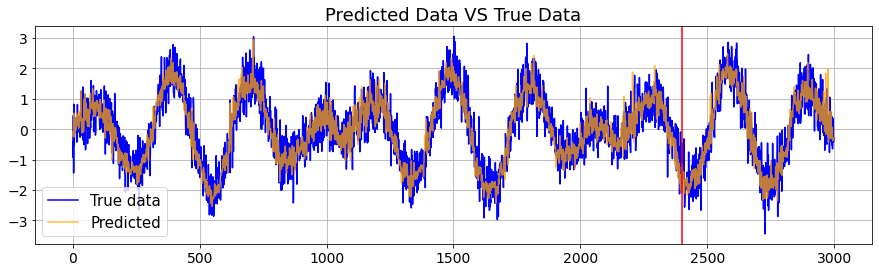


Ran with batch size: 8
Error: [0.4349355631377773]
----------------------------------------------------------------------------------------------------


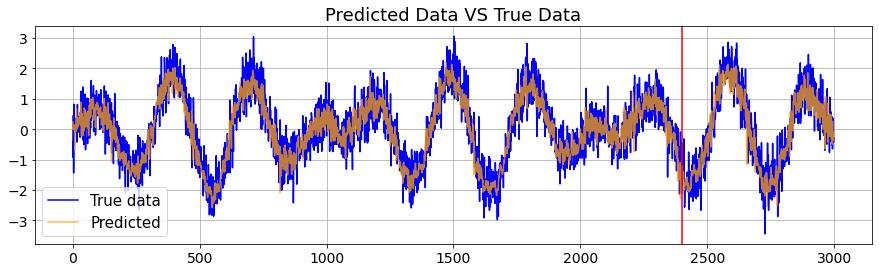


Ran with batch size: 16
Error: [0.4087136687125509]
----------------------------------------------------------------------------------------------------


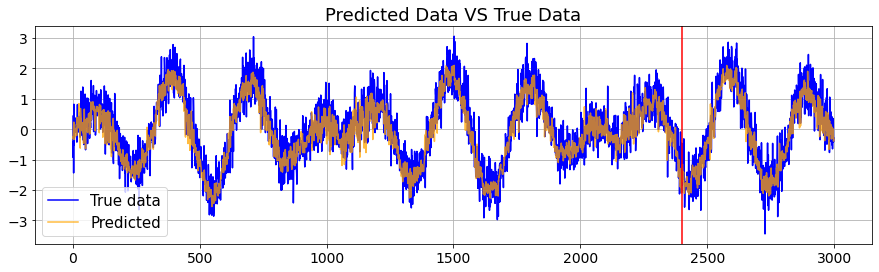


Ran with batch size: 32
Error: [0.40993933425589046]
----------------------------------------------------------------------------------------------------


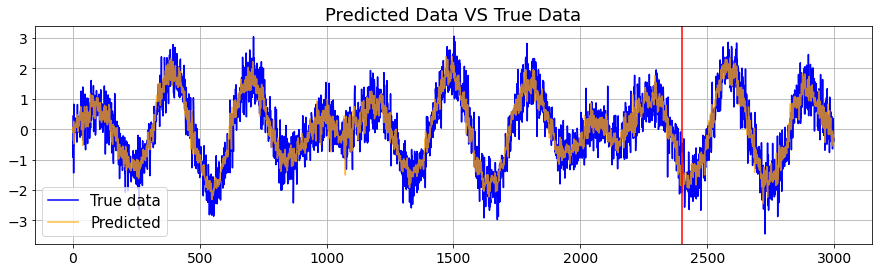


Ran with batch size: 64
Error: [0.407492307459699]
----------------------------------------------------------------------------------------------------


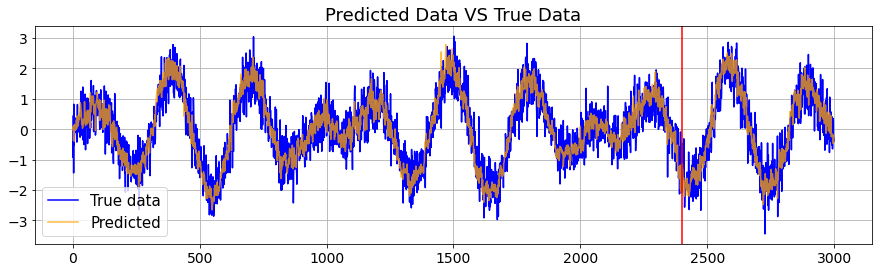

In [162]:
for b in [4, 8, 16, 32, 64]:
    trainX, testX, trainY, testY = prepare_data(8)
    model = build_simple_rnn(num_units=32, num_dense=8, embedding=8)
    batch_size = b
    num_epochs = 250
    model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, verbose=0)
    preds = predictions(model, trainX, testX)
    print("Ran with batch size: {}".format(b))
    print("Error:", errors(testX, df))
    print("-" * 100)
    plot_compare(preds)
    print()

The model ran best with a batch size of 64, which is the highest value we tested for

Error: [0.3234379469943189]


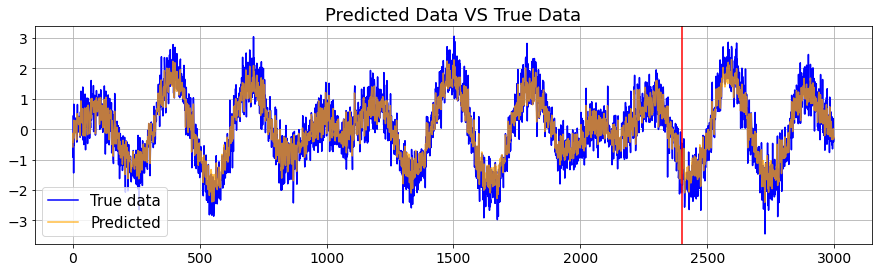

In [164]:
# Running the model with the best values for each parameter
embedding_size = 2
batch_size = 64
num_epochs = 100

trainX, testX, trainY, testY = prepare_data(step=2)
model = build_simple_rnn(num_units=32, num_dense=8, embedding=embedding_size)
model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, verbose=0)
preds = predictions(model, trainX, testX)
print("Error:", errors(testX, df))
plot_compare(preds)

# Conclusions

When comparing the model using an `80/20%` train/test split `VS` the model in the example done in class, which was `25/75% ` train/test, we can observe that the model trained with 80% of the data yielded an error of 0.32, while the model trained with 25% of the data yielded an error of 0.28, using the same parameters. This difference is surprising because in general the more training data the lower the error of the model, unless there is overfitting. 
However, the fact that the dataset is periodical and has noise added to it can cause the model to accumulate errors the more training data we use. It would be interesting to compare the results with those of a different dataset that is not periodical to see the if the model benefits from having more training data (which is what we expect).

## Repasate esto del slicing para arrays de muchas dimensiones

In [178]:
trainX.shape, trainX[:,0].shape, trainX[:,0][:,0].shape

((2400, 1, 2), (2400, 2), (2400,))